In [1]:
from matplotlib import image
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
import numpy 

torch.manual_seed(0)

from density_estimation import * 
from pre_processing import * 

259 200


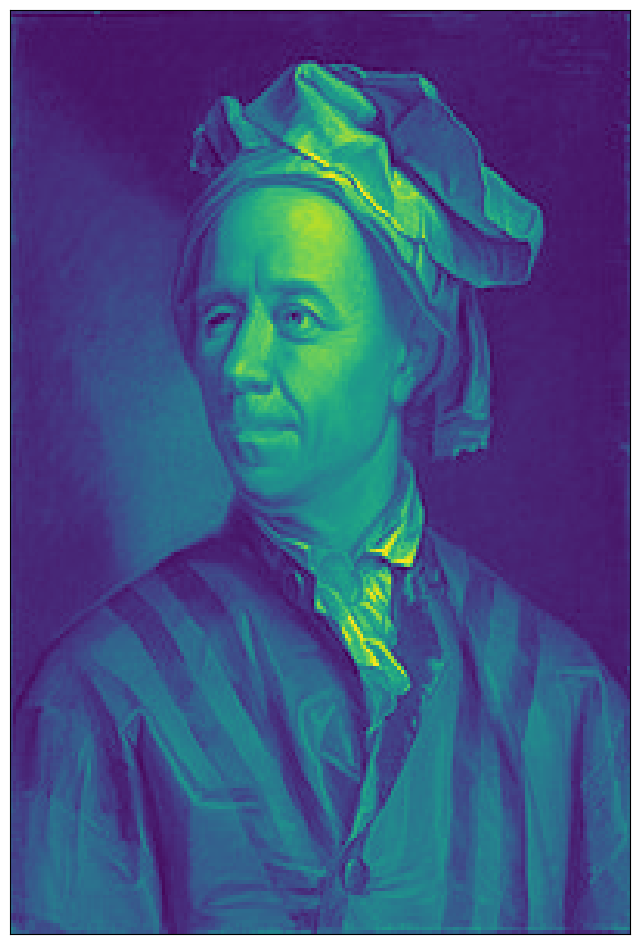

In [2]:
rgb = image.imread("euler.jpg")
lines, columns = rgb.shape[:-1]

def rgb2gray(rgb):
    return numpy.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])
grey = torch.tensor(rgb2gray(rgb))

fig = plt.figure(figsize =(8,12))
plt.tick_params(left = False, right = False , labelleft = False , 
                labelbottom = False, bottom = False) 
plt.imshow(grey, aspect = 'auto')

#Sample data according to image
vector_density = grey.flatten()
vector_density = vector_density/torch.sum(vector_density)
lines, columns = grey.shape
num_samples = 300000
cat = torch.distributions.Categorical(probs = vector_density)
categorical_samples = cat.sample([num_samples])
target_samples = torch.cat([((categorical_samples%columns + torch.rand(num_samples))/columns).unsqueeze(-1),((1-(categorical_samples//columns + torch.rand(num_samples))/lines)).unsqueeze(-1)], dim = -1)

logit_transform = logit(alpha = 1e-2)
transformed_samples = logit_transform.transform(target_samples)

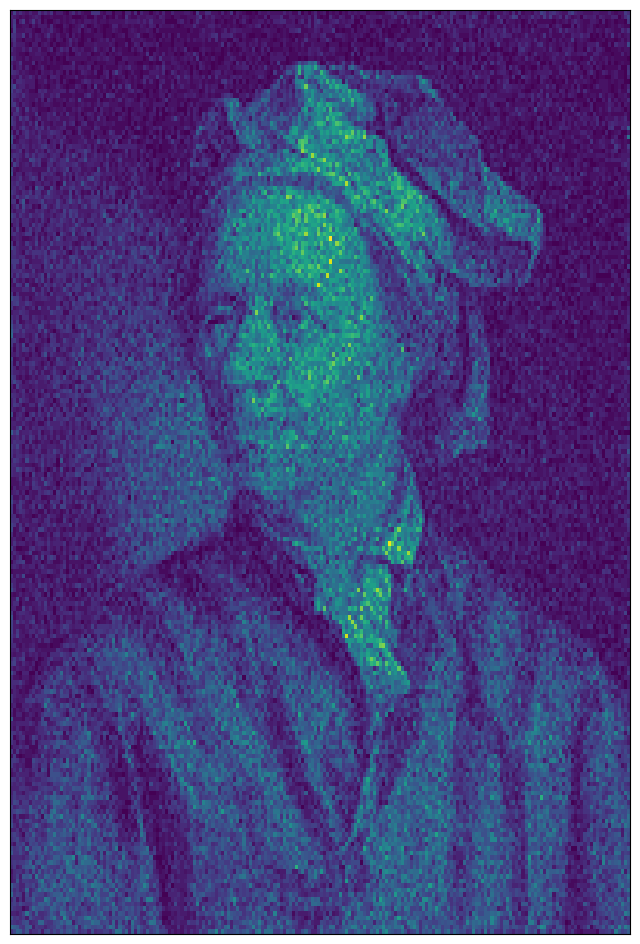

In [3]:
figure = plt.figure(figsize = (8,12))
plt.tick_params(left=False,bottom=False,labelleft=False,labelbottom=False)
plot_image_2d_points(target_samples)

In [4]:
model = DIFDensityEstimator(transformed_samples,50,[128,128,128])
model.initialize_with_EM(50, verbose = True)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [01:05<00:00,  1.31s/it, loss = 3.42065691947937]


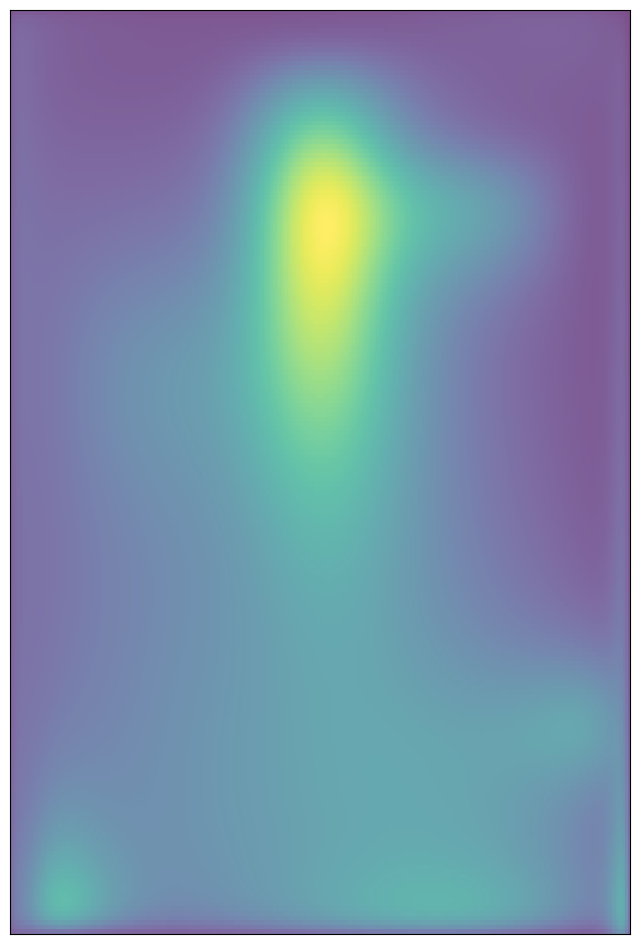

In [5]:
fig = plt.figure(figsize =(8,12))
plt.tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False) 
plot_2d_function(lambda x: torch.exp(model.log_prob(logit_transform.transform(x)) + logit_transform.log_det(x)), bins = (lines, columns), range =([[0.,1.],[0.,1.]]))

In [6]:
model.train(200,10000,lr = 1e-4, weight_decay = 0, verbose = True)
model.train(200,10000,lr = 5e-5, weight_decay = 5e-6, verbose = True)
model.train(200,10000,lr = 1e-5, weight_decay = 5e-6, verbose = True)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [32:10<00:00,  9.65s/it, loss = 3.3732 ; device: cuda]


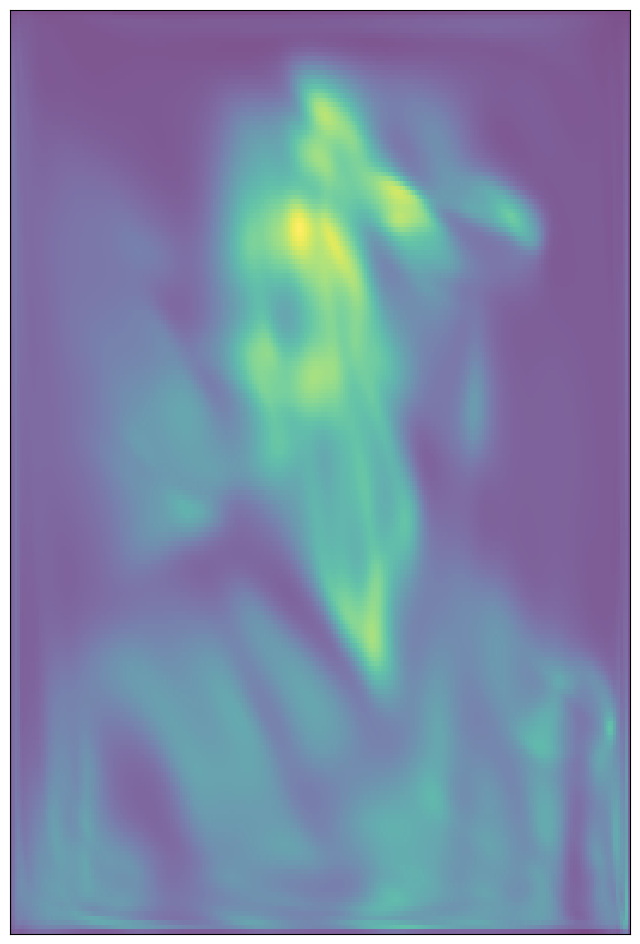

In [7]:
fig = plt.figure(figsize =(8,12))
plt.tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False) 
plot_2d_function(lambda x: torch.exp(model.log_prob(logit_transform.transform(x)) + logit_transform.log_det(x)), bins = (lines, columns), range =([[0.,1.],[0.,1.]]))

In [ ]:
with torch.no_grad():
    grid = torch.cartesian_prod(torch.linspace(0,1,lines),torch.linspace(0,1, columns))
    density = torch.exp(EM.log_density(grid)).reshape(lines,columns).T
    figure = plt.figure(figsize = (12,8))
    plt.tick_params(left=False,bottom=False,labelleft=False,labelbottom=False)
    plt.imshow(torch.flip(torch.flip(density.T,[0,1]),[0,1]),extent = [0,columns,0, lines])
    dif_samples = EM.sample_model(target_samples.shape[0])
    hist_dif_samples, x_edges, y_edges = numpy.histogram2d(dif_samples[:,1].numpy(), dif_samples[:, 0].numpy(), bins = (lines, columns),range = [[0, 1],[0,1]])
    figure = plt.figure(figsize = (12,8))
    plt.tick_params(left=False,bottom=False,labelleft=False,labelbottom=False)
    plt.imshow(torch.flip(torch.flip(torch.tensor(hist_dif_samples).T,[0,1]),[0,1]),extent = [0,columns,0, lines])

In [ ]:
#Run DIF
initial_T = LocationScaleFlow(K,2)
initial_T.m = nn.Parameter(EM.m)
initial_T.log_s = nn.Parameter(EM.log_s)

initial_w = SoftmaxWeight(K, 2, [128,128,128])
initial_w.f[-1].bias = nn.Parameter(EM.log_pi)
initial_w.f[-1].weight = nn.Parameter(torch.zeros(K,initial_w.network_dimensions[-2]))

dif = DIFDensityEstimator(target_samples,K)
dif.T = initial_T
dif.w = initial_w

epochs = 1000
batch_size = 30000
dif.train(epochs, batch_size)

In [ ]:
#Save dif
filename = 'euler_dif.sav'
torch.save(dif,filename)

In [ ]:
with torch.no_grad():
    grid = torch.cartesian_prod(torch.linspace(0,1,lines),torch.linspace(0,1,columns))
    density = torch.exp(dif.log_density(grid)).reshape(lines,columns).T
    figure = plt.figure(figsize = (12,8))
    plt.tick_params(left=False,bottom=False,labelleft=False,labelbottom=False)
    plt.imshow(torch.flip(torch.flip(density.T,[0,1]),[0,1]),extent = [0,columns,0, lines])
    dif_samples = dif.sample_model(target_samples.shape[0])
    hist_dif_samples, x_edges, y_edges = numpy.histogram2d(dif_samples[:,1].numpy(), dif_samples[:, 0].numpy(), bins = (lines, columns),range = [[0, 1],[0,1]])
    figure = plt.figure(figsize = (12,8))
    plt.tick_params(left=False,bottom=False,labelleft=False,labelbottom=False)
    plt.imshow(torch.flip(torch.flip(torch.tensor(hist_dif_samples).T,[0,1]),[0,1]),extent = [0,columns,0, lines])